In [41]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import sys
sys.path.append("..") # Adds higher directory to python modules path.


import seaborn as sns
import matplotlib

plt.rcParams["figure.figsize"] = (20,8)

sns.set_theme()

font = {'family' : 'DejaVu Sans', 'size'   : 25}

matplotlib.rc('font', **font)

import numpy as np
import tensorflow as tf
from tensorflow import keras

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
from StocksDataWrapper import *
from DataHelper import *
from Plots import *

In [43]:
DATA_PATH = '../data/'
FILE_SUFFIX='.txt'

quotation = 'IBM'
price_column = 'Close'
project_label='KerasLSTMRegression'

predict_n = 10

In [44]:
data_wrapper = StocksDataWrapper.read_from(file_path=f"{DATA_PATH}{quotation}{FILE_SUFFIX}", 
                                           compute_features=True, predict_n=predict_n, normalize=True)

data_wrapper.head()

,Date,Open,High,Low,Close,Adjusted,Volume,LowLen,RSI(14),GAP,...,SMA(10),SMA(20),EMA(14),EMA_Diff,SMA(20) - SMA(10),Difference,PercentageDiff,Tendency,NextPrice,Next
0,1962-03-21,0.015428,0.014523,0.015787,0.015429,0.005020,0.003780,0.002525,0.595025,0.000000,...,0.014503,0.013555,0.013679,0.619962,0.394439,0.596761,0.496869,higher,0.012863,lower
1,1962-03-22,0.015334,0.014334,0.015533,0.015051,0.004897,0.003456,0.000000,0.456905,0.001641,...,0.014474,0.013587,0.013637,0.619512,0.394997,0.595125,0.477865,lower,0.013540,higher
2,1962-03-23,0.015113,0.014271,0.015565,0.015177,0.004938,0.002700,0.000000,0.505305,0.000410,...,0.014436,0.013619,0.013618,0.619054,0.395653,0.594787,0.474037,higher,0.013508,lower
3,1962-03-26,0.015207,0.014334,0.015597,0.015162,0.004933,0.001944,0.001263,0.499957,0.000000,...,0.014399,0.013656,0.013600,0.618669,0.396346,0.594843,0.474674,lower,0.013540,higher
4,1962-03-27,0.015113,0.014114,0.014963,0.014516,0.004723,0.005076,0.000842,0.332912,0.001026,...,0.014300,0.013658,0.013496,0.617898,0.397285,0.592643,0.449242,lower,0.013666,higher


In [45]:
df = data_wrapper.df
feature_names = data_wrapper.feature_names

In [46]:

data_columns = ['Close', 'Volume'] + feature_names
data_columns = ['Close', 'Volume', 'MACD_diff', 'RSI(14)', 'PercentageDiff', 'LowLen', 'RSI_diff']
data_columns += [y_column]


dataset = df.copy()
dataset = dataset.loc[:, data_columns]

for col in dataset.columns:
    dataset[col] = dataset[col].replace({'higher':1, 'stay':0, 'lower':0})
    

    
    X = dataset.loc[:, dataset.columns != y_column]
    y = dataset[y_column]

X.head()

,Close,Volume,MACD_diff,RSI(14),PercentageDiff,LowLen,RSI_diff
0,0.015429,0.003780,0.546478,0.595025,0.496869,0.002525,0.534925
1,0.015051,0.003456,0.545495,0.456905,0.477865,0.000000,0.400670
2,0.015177,0.002700,0.545121,0.505305,0.474037,0.000000,0.386443
3,0.015162,0.001944,0.544865,0.499957,0.474674,0.001263,0.393389
4,0.014516,0.005076,0.543437,0.332912,0.449242,0.000842,0.268441


In [7]:
from sklearn.model_selection import train_test_split
TEST_SIZE = 0.3

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

X_test = X_test.sort_index()
y_test = y_test.sort_index()

print(f"Train size : {len(X_train)}, test_size : {len(X_test)}")

Train size : 10351, test_size : 4437


https://keras.io/examples/timeseries/timeseries_weather_forecasting/

In [8]:
seq_len=5

train_dataset = keras.preprocessing.timeseries_dataset_from_array(
    X_train,
    y_train,
    sequence_length=seq_len,
    batch_size=32,
)


val_dataset = keras.preprocessing.timeseries_dataset_from_array(
    X_test,
    y_test,
    sequence_length=seq_len,
    batch_size=32,
)


In [28]:
for batch in train_dataset.take(1):
    inputs, targets = batch
    print(f"Inputs : {inputs[:1]}, {targets[:1]}")
    print(X_train[:seq_len+1])
    print(y_train[:10])

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Inputs : [[[0.63371433 0.06832631 0.49479806 0.38247274 0.42569408 0.04798044
   0.45578773]
  [0.49378896 0.11482086 0.60961478 0.53565195 0.57193266 0.0473485
   0.70148334]
  [0.05848526 0.00927357 0.532866   0.29282192 0.39951661 0.00157816
   0.32501134]
  [0.05441887 0.04246256 0.54192949 0.30365261 0.45381422 0.0049322
   0.43061285]
  [0.17128164 0.06220777 0.52920086 0.60384773 0.53329316 0.01578283
   0.6190346 ]]], [0.63489514]
          Close    Volume  MACD_diff   RSI(14)  PercentageDiff    LowLen  \
13501  0.633714  0.068326   0.494798  0.382473        0.425694  0.047980   
9563   0.493789  0.114821   0.609615  0.535652        0.571933  0.047348   
1975   0.058485  0.009274   0.532866  0.292822        0.399517  0.001578   
3912   0.054419  0.042463   0.541929  0.303653        0.453814  0.004932   
6334   0.171282  0.062208   0.529201  0.603848        0.533293  0.015783   
4411   0.054530  0.034473   0.531664  0.325185        0.378136  0.003946   

       RSI_diff  
13501 

In [10]:
from tensorflow.keras import layers

inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5, 7)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                5120      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 5,153
Trainable params: 5,153
Non-trainable params: 0
_________________________________________________________________


In [11]:
history = model.fit(
    train_dataset,
    epochs=20,
    shuffle=True,
)

Epoch 1/20
324/324 [==============================] - 2s 3ms/step - loss: 0.0660
Epoch 2/20
324/324 [==============================] - 1s 3ms/step - loss: 0.0040
Epoch 3/20
324/324 [==============================] - 1s 3ms/step - loss: 0.0017
Epoch 4/20
324/324 [==============================] - 1s 4ms/step - loss: 0.0012
Epoch 5/20
324/324 [==============================] - 1s 4ms/step - loss: 9.8782e-04
Epoch 6/20
324/324 [==============================] - 1s 4ms/step - loss: 8.7167e-04
Epoch 7/20
324/324 [==============================] - 1s 4ms/step - loss: 8.1434e-04
Epoch 8/20
324/324 [==============================] - 1s 4ms/step - loss: 7.6319e-04
Epoch 9/20
324/324 [==============================] - 1s 4ms/step - loss: 7.1705e-04
Epoch 10/20
324/324 [==============================] - 1s 4ms/step - loss: 6.7851e-04
Epoch 11/20
324/324 [==============================] - 1s 4ms/step - loss: 6.4640e-04
Epoch 12/20
324/324 [==============================] - 1s 4ms/step - loss: 6.19

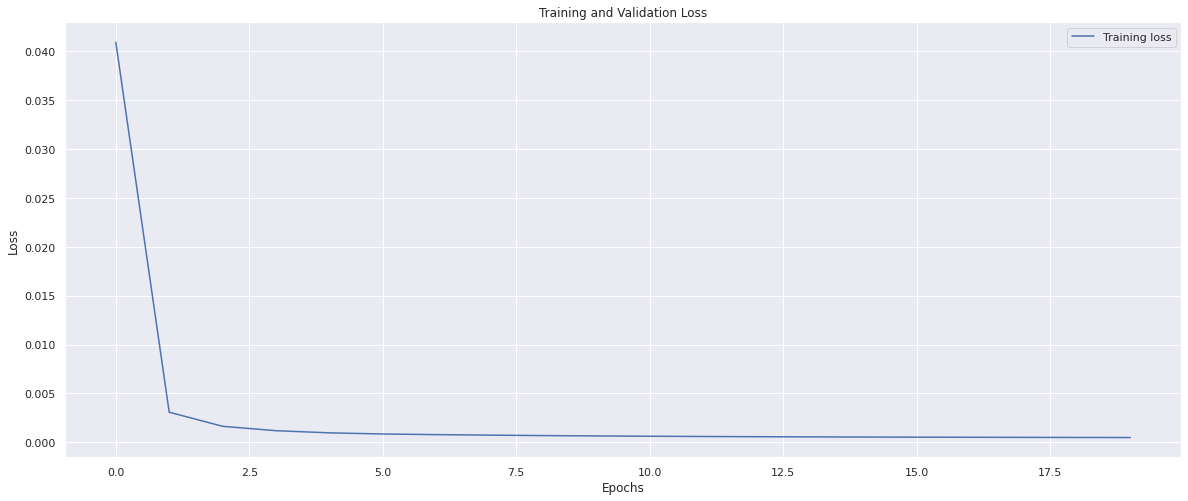

In [12]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

In [13]:
predictions = np.array([])
labels = np.array([])

for x, y in tqdm(val_dataset):
    predictions = np.concatenate([predictions, model.predict(x).flatten()])
    labels = np.concatenate([labels,y])
    

  0%|          | 0/139 [00:00<?, ?it/s]

In [14]:
from sklearn.metrics import mean_squared_error
print(f"MSE : {mean_squared_error(y_pred=predictions, y_true=labels)}")

MSE : 0.0005686937069365795


In [15]:
print(predictions)
print(labels)

[0.02564635 0.0250633  0.01560769 ... 0.55475551 0.58158189 0.58750993]
[0.0128629  0.0135399  0.01331948 ... 0.5697147  0.57094274 0.57372946]


In [16]:
test_df = pd.DataFrame(data={'Close':predictions})
scaled_preds = data_wrapper.get_unscaled_data(df=test_df)['Close']
test_df = pd.DataFrame(data={'Close':labels})
scaled_labels = data_wrapper.get_unscaled_data(df=test_df)['Close']

In [17]:
print(scaled_preds)
print(scaled_labels)

0         9.509846
1         9.386402
2         7.384461
3         7.694134
4         7.341451
           ...    
4428    122.337949
4429    122.085875
4430    121.532838
4431    127.212520
4432    128.467604
Name: Close, Length: 4433, dtype: float64
0         6.803333
1         6.946667
2         6.900000
3         6.833333
4         6.660000
           ...    
4428    124.620003
4429    127.199997
4430    124.699997
4431    124.959999
4432    125.550003
Name: Close, Length: 4433, dtype: float64


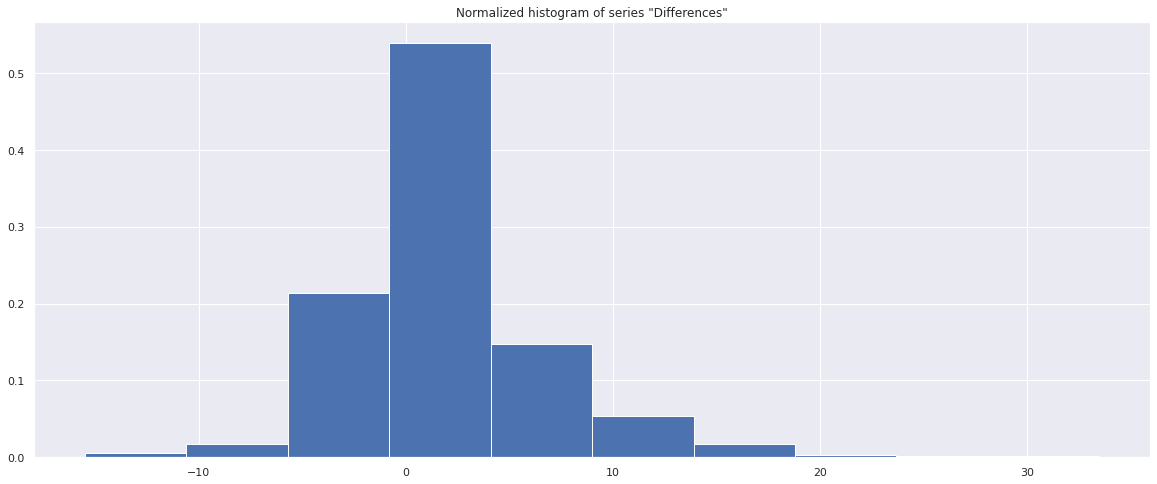

In [18]:
plot_normalized_histogram(series=pd.Series([p - y for p,y in zip(scaled_preds, scaled_labels)], name="Differences"))
plt.show()

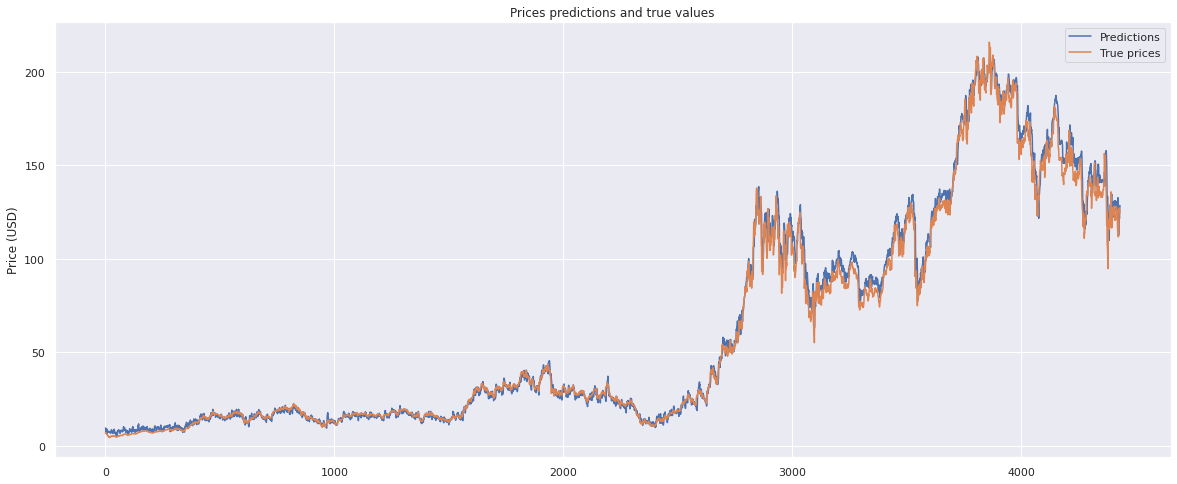

In [19]:
ax = plt.gca()
ax.plot(scaled_preds, label="Predictions")
ax.plot(scaled_labels, label="True prices")
plt.title("Prices predictions and true values")
plt.ylabel("Price (USD)")
plt.legend(loc='best')
plt.show()

In [20]:
import lime
from lime import lime_tabular

# https://stackoverflow.com/questions/56226621/how-to-extract-data-labels-back-from-tensorflow-dataset
training_samples = np.concatenate([x for x, y in train_dataset], axis=0)
training_labels = np.concatenate([y for x, y in train_dataset], axis=0)

for batch in train_dataset.as_numpy_iterator():
    inputs, targets = batch
    #print(inputs, targets)
    break

explainer = lime_tabular.RecurrentTabularExplainer(inputs, training_labels=targets,
                                                   discretize_continuous = True,
                                                   feature_names=X_train.columns.values,
                                                   verbose=True, mode='regression')

In [21]:
test_samples = np.concatenate([x for x, y in val_dataset], axis=0)

print(test_samples.shape)

(4433, 5, 7)


In [22]:
# https://github.com/marcotcr/lime/blob/master/doc/notebooks/Submodular%20Pick%20examples.ipynb

import warnings
from lime import submodular_pick
sp_obj = submodular_pick.SubmodularPick(explainer, training_samples, model.predict, 
                                        sample_size=15, num_features=10, num_exps_desired=5)

Intercept 0.4338371107973861
Prediction_local [-0.03762483]
Right: 0.015458921
Intercept 0.40605956374831476
Prediction_local [0.04027491]
Right: 0.058337167
Intercept 0.39310289656843833
Prediction_local [0.0493513]
Right: 0.11464725
Intercept 0.28713894194086326
Prediction_local [0.38912242]
Right: 0.44836208
Intercept 0.3874358916828286
Prediction_local [0.06741073]
Right: 0.12721957
Intercept 0.30750486164293156
Prediction_local [0.33311358]
Right: 0.5180637
Intercept 0.29762026713216294
Prediction_local [0.34142099]
Right: 0.38153926
Intercept 0.2986054978313016
Prediction_local [0.33223385]
Right: 0.4143698
Intercept 0.38122986854086327
Prediction_local [0.07001531]
Right: 0.11947579
Intercept 0.4018439277233885
Prediction_local [0.01828265]
Right: 0.044301152
Intercept 0.39861432564591737
Prediction_local [0.01881466]
Right: 0.054526567
Intercept 0.41601974533743385
Prediction_local [-0.01443565]
Right: 0.020188788
Intercept 0.4011590150338345
Prediction_local [0.0478001]
Right:

[<Figure size 1440x576 with 1 Axes>,
 <Figure size 1440x576 with 1 Axes>,
 <Figure size 1440x576 with 1 Axes>,
 <Figure size 1440x576 with 1 Axes>,
 <Figure size 1440x576 with 1 Axes>]

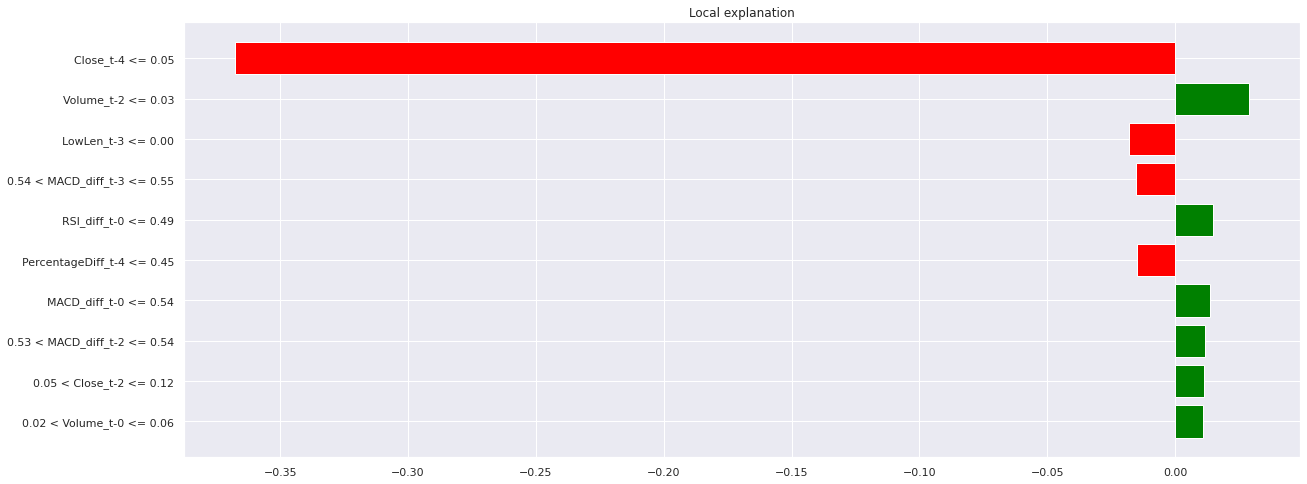

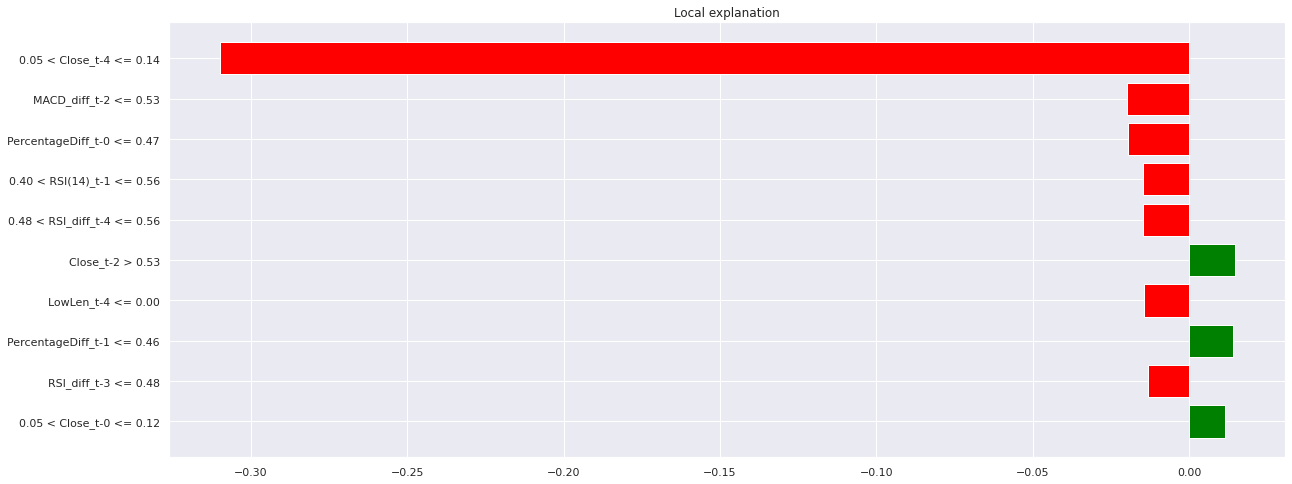

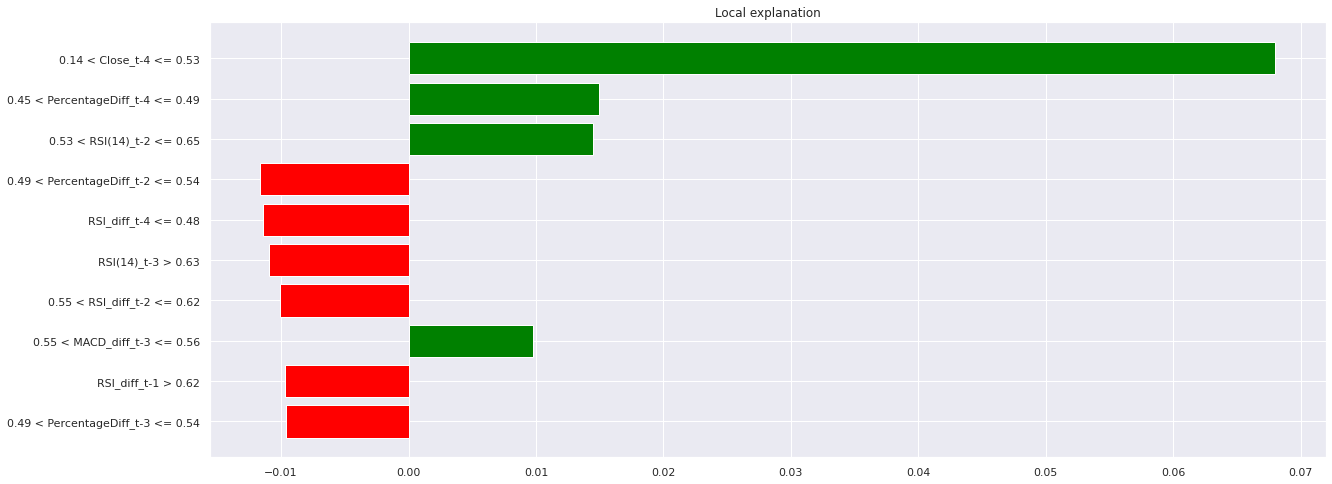

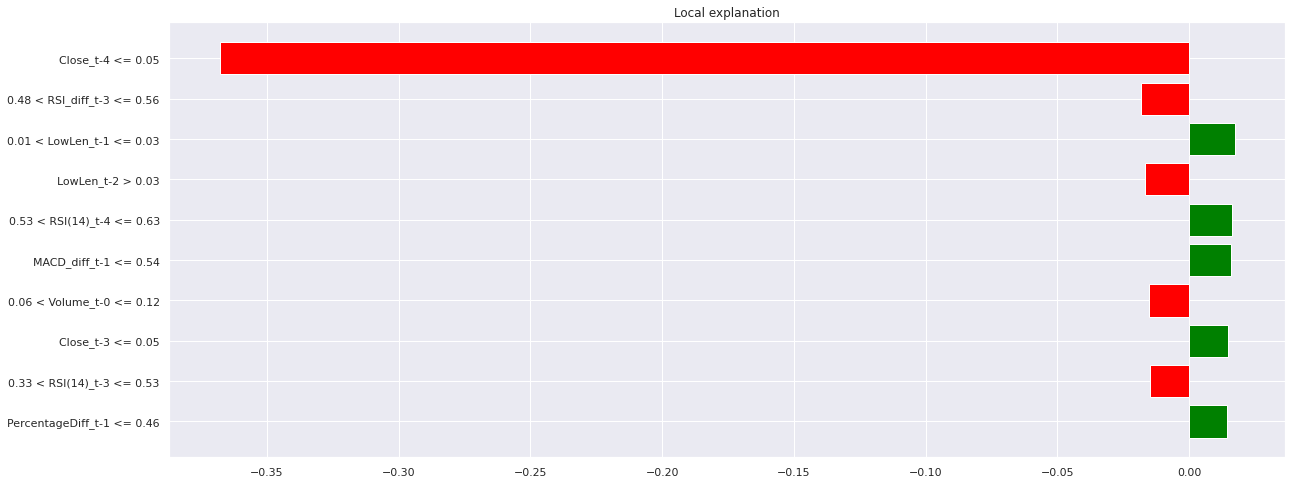

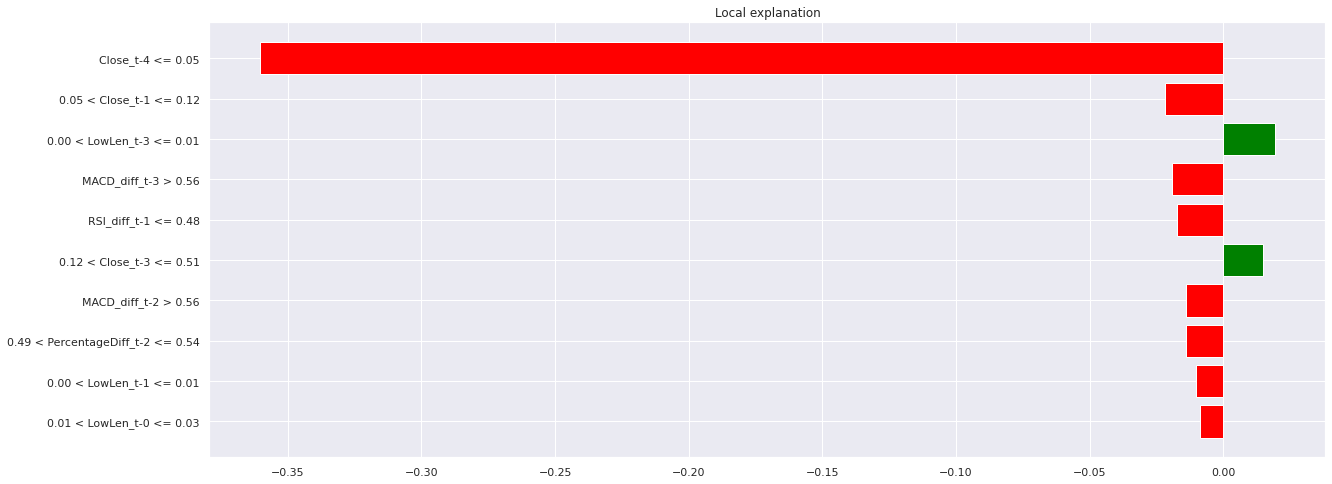

In [23]:
explanations = list(sp_obj.sp_explanations)

#print(len(explanations))

[exp.as_pyplot_figure(label=1) for exp in sp_obj.sp_explanations]

(14783, 5, 32)
